Sentiment Analysis of App Reviews for Requirement Engineering

File Paths and Library Imports

In [2]:
# Define file paths for the input and output data

data_path = 'C:/Users/aparn/Desktop/My Folder/MDS - UoM/Semester 2/Dissertation/SentimentTrack/data/reviews.csv'
senti_score_reviews_path = 'C:/Users/aparn/Desktop/My Folder/MDS - UoM/Semester 2/Dissertation/SentimentTrack/data/senti_score_reviews.csv'
nlp_processed_reviews_path = 'C:/Users/aparn/Desktop/My Folder/MDS - UoM/Semester 2/Dissertation/SentimentTrack/data/nlp_processed_reviews.csv'
Xtrain_bow_textrep_reviews_path = 'C:/Users/aparn/Desktop/My Folder/MDS - UoM/Semester 2/Dissertation/SentimentTrack/data/Xtrain_bow_textrep_reviews1.csv'
Xtest_bow_textrep_reviews_path = 'C:/Users/aparn/Desktop/My Folder/MDS - UoM/Semester 2/Dissertation/SentimentTrack/data/Xtest_bow_textrep_reviews1.csv'
bow_vocabulary_path = 'C:/Users/aparn/Desktop/My Folder/MDS - UoM/Semester 2/Dissertation/SentimentTrack/data/word_indices.pkl'
glove_vocabulary_path = 'C:/Users/aparn/Desktop/My Folder/MDS - UoM/Semester 2/Dissertation/SentimentTrack/data/glove_vocabulary.pkl'
senti_jar_path = 'C:/Users/aparn/Desktop/My Folder/MDS - UoM/Semester 2/Dissertation/SentimentTrack/data/SentiStrength.jar'
senti_lang_path = 'C:/Users/aparn/Desktop/My Folder/MDS - UoM/Semester 2/Dissertation/SentimentTrack/data/SentiStrength_Data/'
vocabulary_path = 'C:/Users/aparn/Desktop/My Folder/MDS - UoM/Semester 2/Dissertation/SentimentTrack/data//bow_vocabulary.pkl'
Xtrain_data_path = 'C:/Users/aparn/Desktop/My Folder/MDS - UoM/Semester 2/Dissertation/SentimentTrack/data/Xtrain_reviews_path.csv'
Xtest_data_path = 'C:/Users/aparn/Desktop/My Folder/MDS - UoM/Semester 2/Dissertation/SentimentTrack/data/Xtest_reviews_path.csv'
pretrained_glove_path = 'C:/Users/aparn/Desktop/My Folder/MDS - UoM/Semester 2/Dissertation/SentimentTrack/data/glove.small.txt'
Xtrain_glove_textrep_reviews_path = 'C:/Users/aparn/Desktop/My Folder/MDS - UoM/Semester 2/Dissertation/SentimentTrack/data/Xtrain_glove_textrep_reviews1.csv'
Xtest_glove_textrep_reviews_path = 'C:/Users/aparn/Desktop/My Folder/MDS - UoM/Semester 2/Dissertation/SentimentTrack/data/Xtest_glove_textrep_reviews1.csv'


In [3]:
# Import necessary libraries
import pandas as pd                    # For data manipulation and analysis
import subprocess                      # For running external processes
import re                              # For regular expressions
import string                          # For string manipulation
import nltk                            # Natural Language Toolkit for text processing
from nltk.stem import WordNetLemmatizer, PorterStemmer  # Text preprocessing tools
from nltk.tokenize import word_tokenize  # Tokenization of text
import numpy as np                     # For numerical computations
from sklearn.model_selection import train_test_split  # For splitting data into training and testing sets
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score  # Metrics for evaluation
from tensorflow import keras          # Deep learning framework
from tensorflow.keras.models import Sequential  # Sequential neural network model
from tensorflow.keras.layers import Dense  # Dense layers for neural networks
import ast                             # For handling abstract syntax trees
import time                            # For measuring time
from sklearn.linear_model import LogisticRegression  # Logistic Regression classifier
from sklearn.model_selection import cross_val_score  # Cross-validation scoring
from sklearn.naive_bayes import MultinomialNB  # Multinomial Naive Bayes classifier
import matplotlib.pyplot as plt        # For plotting
import torch                           # PyTorch for deep learning
import pickle                          # For serializing Python objects
from sklearn.tree import DecisionTreeClassifier  # Decision Tree classifier
from keras.layers import Embedding, Flatten, Conv1D  # Keras layers for deep learning
from sklearn import svm                # Support Vector Machine classifier

C:\Users\aparn\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Phase 1: Initial Labelling of Unlabelled data using SentiStrength Tool

In [4]:
# Load the app review data
reviews_df = pd.read_csv(data_path, encoding='latin-1')

def preprocess_text(text):
    """
    Preprocesses the given text by converting it to lowercase, removing punctuation, and emoticons.

    Args:
        text (str): The input text to preprocess.

    Returns:
        str: The preprocessed text.
    """
    # Convert text to lowercase
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove emoticons (you can customize this regex pattern based on your data)
    emoticon_pattern = re.compile("["
                                  u"\U0001F600-\U0001F64F"  # emoticons
                                  u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                  u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                  u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                  "]+", flags=re.UNICODE)
    text = emoticon_pattern.sub(r'', text)
    return text

# Define a function to apply SentiStrength sentiment analysis on each review
def get_sentiment(review):
    """
    Applies SentiStrength sentiment analysis to the given review text and returns positive and negative scores.

    Args:
        review (str): The review text to analyze.

    Returns:
        tuple: A tuple containing positive and negative sentiment scores.
    """
    # review = preprocess_text(review)  # Optional text preprocessing
    process = subprocess.Popen(['java', '-jar', senti_jar_path, 'sentidata', senti_lang_path, 'text', review],
                               stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()
    scores_str = stdout.decode('utf-8').strip()
    if scores_str:
        scores = scores_str.split('\t')
        sentiment_scores = []
        for s in scores:
            try:
                pos_score, neg_score = map(int, s.split())
                sentiment_scores.append((pos_score, neg_score))
            except ValueError:
                pass  # Ignore non-integer sentiment scores
        if sentiment_scores:
            negative_score = min([s[0] for s in sentiment_scores])
            positive_score = max([s[1] for s in sentiment_scores])
            return positive_score, negative_score
    else:
        return 0, 0

# Apply SentiStrength sentiment analysis on each review and store the scores in two new columns
reviews_df[['negative_score', 'positive_score']] = reviews_df['review'].apply(get_sentiment).apply(pd.Series)

# Display the results
pd.set_option('display.max_colwidth', None)
reviews_df[['review','positive_score','negative_score']]

# Save the DataFrame with sentiment scores to a CSV file
reviews_df.to_csv(senti_score_reviews_path, index=False)

,review,positive_score,negative_score
0,Great app! The new version now works on my Bravia Android TV which is great as it's right by my rooftop aerial cable. The scan feature would be useful...any ETA on when this will be available? Also the option to import a list of bookmarks e.g. from a simple properties file would be useful.,4,-1
1,Great It's not fully optimised and has some issues with crashing but still a nice app especially considering the price and it's open source.,3,-1
2,Works on a Nexus 6p I'm still messing around with my hackrf but it works with my Nexus 6p Trond usb-c to usb host adapter. Thanks!,3,-1
3,The bandwidth seemed to be limited to maximum 2 MHz or so. I tried to increase the bandwidth but not possible. I purchased this is because one of the pictures in the advertisement showed the 2.4GHz band with around 10MHz or more bandwidth. Is it not possible to increase the bandwidth? If not it is just the same performance as other free APPs.,1,-1
4,Works well with my Hackrf Hopefully new updates will arrive for extra functions,1,-1


Phase 2: Data Preprocessing

In [5]:
# Load the app review data
reviews_df = pd.read_csv(senti_score_reviews_path, encoding='latin-1')

def preprocess_text(text):
    """
    Preprocesses the given text by converting it to lowercase, removing punctuation, stopwords,
    lemmatization, and stemming.

    Args:
        text (str): The input text to preprocess.

    Returns:
        str: The preprocessed text.
    """
    # Convert text to lowercase
    clean_text = text.lower()

    # Remove punctuation
    clean_text = remove_punctuation(clean_text)

    # Remove stopwords
    clean_text = remove_stopwords(clean_text)

    # Lemmatize the text
    preprocessed_text = lemmatize_text(clean_text)

    # Stem the text
    preprocessed_text = stem_text(preprocessed_text)

    return preprocessed_text


def remove_punctuation(text):
    """
    Removes punctuation from the given text.

    Args:
        text (str): The input text.

    Returns:
        str: The text without punctuation.
    """
    # Create a translation table with punctuation characters mapped to None
    translator = str.maketrans('', '', string.punctuation)
    
    # Remove punctuation using the translation table
    text_without_punct = text.translate(translator)
    
    return text_without_punct


def remove_stopwords(clean_text):
    """
    Removes common stopwords from the given text.

    Args:
        clean_text (str): The preprocessed text.

    Returns:
        str: The text with stopwords removed.
    """
    stopwords = [...]  # List of common stopwords
    
    tokenized_words  = clean_text.split()

    # Remove the stop words from the text
    filtered_words = [word for word in tokenized_words if word not in stopwords]
    
    # Join the filtered words back into a single string
    cleaned_text = " ".join(filtered_words)
    
    return cleaned_text

def lemmatize_text(text):
    """
    Lemmatizes the words in the given text.

    Args:
        text (str): The input text.

    Returns:
        str: The lemmatized text.
    """
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in tokens]
    lemmatized_text = " ".join(lemmatized_words)
    return lemmatized_text

def stem_text(text):
    """
    Stems the words in the given text.

    Args:
        text (str): The input text.

    Returns:
        str: The stemmed text.
    """
    stemmer = PorterStemmer()
    tokens = word_tokenize(text)
    stemmed_words = [stemmer.stem(word) for word in tokens]
    stemmed_text = " ".join(stemmed_words)
    return stemmed_text

# Apply the preprocessing functions to each review and store the results in a new column
reviews_df[['preprocessed_text']] = reviews_df['review'].apply(preprocess_text).apply(pd.Series)

# Ensure the 'preprocessed_text' column is of string data type
reviews_df['preprocessed_text'] = reviews_df['preprocessed_text'].astype(str)

# Save the DataFrame with preprocessed text to a CSV file
reviews_df.to_csv(nlp_processed_reviews_path, index=False)


Phase 3: Data Split and EDA:

In [4]:
# Train Test Split:

# Load the app review data
reviews_df = pd.read_csv(nlp_processed_reviews_path, encoding='latin-1')

# Separate features (reviews) and labels (positive_score and negative_score)
X = reviews_df['preprocessed_text']
y_positive = reviews_df['positive_score'].tolist()
y_negative = reviews_df['negative_score'].tolist()

# Combine positive and negative values into a single target label
y = [1 if abs(pos_score) > abs(neg_score) else 0 for pos_score, neg_score in zip(y_positive, y_negative)]
reviews_df['label'] = y

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Save the training and test data to CSV files
X_train.to_csv(Xtrain_data_path, index=False)
X_test.to_csv(Xtest_data_path, index=False)


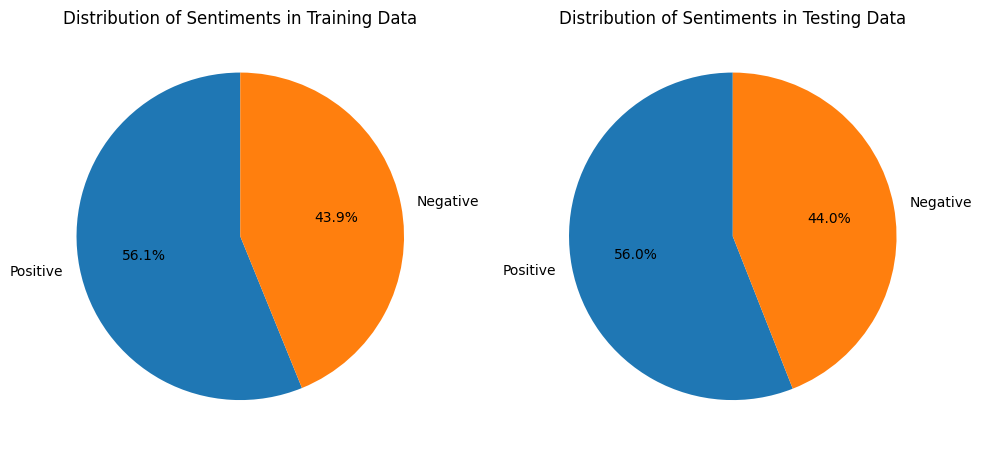

In [5]:
# Assuming y_train and y_test contain the labels (0 for negative and 1 for positive)
positive_train = sum(y_train)
negative_train = len(y_train) - positive_train

positive_test = sum(y_test)
negative_test = len(y_test) - positive_test

# Data for pie charts
train_data = [positive_train, negative_train]
test_data = [positive_test, negative_test]

# Labels for pie charts
labels = ['Positive', 'Negative']

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot for training data
axes[0].pie(train_data, labels=labels, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Distribution of Sentiments in Training Data')

# Plot for testing data
axes[1].pie(test_data, labels=labels, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Distribution of Sentiments in Testing Data')

# Adjust layout
plt.tight_layout()
plt.show()

Phase 4: Text Representation

BoW Random Representation

In [13]:
# Load the app review data
train_reviews_df = pd.read_csv(Xtrain_data_path, encoding='latin-1')

# Define a list of punctuation marks to be removed from text
PUNCTUATIONS = [',', '.', ';', ':', '!', '?']

def BoW(training_reviews):
    # Initialize a custom vocabulary list and count dictionary
    custom_vocab_list = []
    custom_vocab_count = {}
    
    # Initialize word_indices with default values for padding and unknown words
    word_indices = {"#PAD#": 0, "#UNK#": 1}
    
    # Define the maximum sentence length
    max_sentence_length = 400
    
    # Iterate through training reviews
    for review in training_reviews:
        if not isinstance(review, str):
            custom_vocab_list.append(' ')  # Skip non-string elements
        else:
            custom_vocab_list += review.split(' ')

    # Count the occurrences of each word in the custom vocabulary
    for word in custom_vocab_list:
        custom_vocab_count[word] = custom_vocab_count.get(word, 0) + 1

    # Assign unique indices to words based on their frequency
    idx_counter = 2
    for word in custom_vocab_count.keys():
        word_indices[word] = idx_counter
        idx_counter += 1

    # Create Bag of Words (BoW) vectors for each review
    bow_vectors = [] 
    for review in training_reviews:
        if not isinstance(review, str):
            tokens = ['#UNK#']  # Skip non-string elements
        else:
            tokens = review.split()
        
        # Map words to their corresponding indices in the vocabulary
        sent_indices = [word_indices.get(token, word_indices["#UNK#"]) for token in tokens]
        
        # Pad the sequences to the specified maximum sentence length
        if len(sent_indices) < max_sentence_length:
            sent_indices += [word_indices["#PAD#"]] * (max_sentence_length - len(sent_indices))
        
        # Append the BoW vector for the review
        bow_vectors.append(sent_indices)
    
    return bow_vectors, word_indices

# Extract preprocessed text reviews
reviews = train_reviews_df['preprocessed_text']

# Generate BoW vectors and word indices
bow_vectors, word_indices = BoW(reviews)

# Add BoW vectors to the DataFrame
train_reviews_df['bow_vector'] = bow_vectors

# Save the word_indices to a file using pickle
with open(bow_vocabulary_path, "wb") as f:
    pickle.dump(word_indices, f)

# Save the DataFrame with BoW vectors
train_reviews_df.to_csv(Xtrain_bow_textrep_reviews_path, index=False)


In [14]:
# Assuming you have already loaded the test reviews into 'test_reviews_df'
# Load the app review data
test_reviews_df = pd.read_csv(Xtest_data_path, encoding='latin-1')

# Load the word_indices from the file using pickle
with open(bow_vocabulary_path, "rb") as f:
    word_indices = pickle.load(f)

def BoW_test(test_reviews, word_indices):
    """
    Generate Bag of Words (BoW) representations for a list of preprocessed test reviews using pre-loaded word indices.

    Parameters:
        test_reviews (list): List of preprocessed test reviews.
        word_indices (dict): Dictionary mapping words to their corresponding indices.

    Returns:
        bow_vectors (list): List of BoW representations for the input test reviews.
    """
    max_sentence_length = 400
    bow_vectors = []

    for review in test_reviews:
        if not isinstance(review, str):
            tokens = ['#UNK#']  # Skip non-string elements
        else:
            tokens = review.split()
        sent_indices = [word_indices.get(token, word_indices["#UNK#"]) for token in tokens]
        if len(sent_indices) < max_sentence_length:
            sent_indices += [word_indices["#PAD#"]] * (max_sentence_length - len(sent_indices))
        bow_vectors.append(sent_indices)
    return bow_vectors

# Extract preprocessed test text reviews
test_reviews = test_reviews_df['preprocessed_text']

# Generate BoW representations for test reviews using pre-loaded word indices
test_bow_vectors = BoW_test(test_reviews, word_indices)

# Add BoW representations to the test DataFrame
test_reviews_df['bow_vector'] = test_bow_vectors

# Save the test DataFrame with BoW representations
test_reviews_df.to_csv(Xtest_bow_textrep_reviews_path, index=False)

BoW GloVe Representation

In [19]:
def get_pretrained_embeddings(glove_path):
    """
    Load pre-trained GloVe word embeddings from a file and create an embedding dictionary.

    Parameters:
        glove_path (str): Path to the GloVe embeddings file.

    Returns:
        emb_dict_glove (dict): Dictionary mapping words to their corresponding word vectors.
        embeddings_glove (list): List of word vectors.
    """
    embeddings_glove = []
    emb_dict_glove = {}

    # Open and read the GloVe embeddings file
    with open(glove_path, 'rt', encoding='utf-8') as glove_file:
        pretrained_vectors = glove_file.read().strip().split('\n')

    # Parse each line of the GloVe file to extract word vectors
    for vector in range(len(pretrained_vectors)):
        word = pretrained_vectors[vector].split("\t")[0]
        word_vector = [float(val) for val in pretrained_vectors[vector].split('\t')[1].split(' ')[0:]]
        embeddings_glove.append(word_vector)
        emb_dict_glove[word] = word_vector

    return emb_dict_glove, embeddings_glove

def get_glove_representation(reviews):
    """
    Generate GloVe representations for a list of preprocessed text reviews.

    Parameters:
        reviews (list): List of preprocessed text reviews.

    Returns:
        glove_rep (list): List of GloVe representations for the input reviews.
        word_indices (dict): Dictionary mapping words to their corresponding indices.
    """
    max_sentence_length = 400

    # Load pre-trained GloVe embeddings and create the embedding dictionary
    emb_dict_glove_bow, embeddings = get_pretrained_embeddings(pretrained_glove_path)

    # Add a zero vector for the '#PAD#' token
    zeroes = [0 for i in range(max_sentence_length)]
    embeddings.append(zeroes)

    # Create word indices
    word_indices = {}
    idx_counter = 0
    for word in emb_dict_glove_bow.keys():
        word_indices[word] = idx_counter
        idx_counter = idx_counter + 1
    word_indices["#PAD#"] = idx_counter
    word_indices["#UNK#"] = idx_counter + 1

    # Generate GloVe representations for the input reviews
    glove_rep = []
    for review in reviews:
        if not isinstance(review, str):
            tokens.append('#UNK#')  # Skip non-string elements
        else:
            tokens = review.split()
        sent_indices = [word_indices.get(token, word_indices["#UNK#"]) for token in tokens]
        if len(sent_indices) < max_sentence_length:
            sent_indices += [word_indices["#PAD#"]] * (max_sentence_length - len(sent_indices))
        glove_rep.append(sent_indices)

    return glove_rep, word_indices

# Extract preprocessed text reviews
reviews = train_reviews_df['preprocessed_text']

# Generate GloVe representations and word indices
glove_vectors, word_indices = get_glove_representation(reviews)

# Add GloVe representations to the DataFrame
train_reviews_df['glove_vector'] = glove_vectors

# Save the word_indices to a file using pickle
with open(glove_vocabulary_path, "wb") as f:
    pickle.dump(word_indices, f)

# Save the DataFrame with GloVe representations
train_reviews_df.to_csv(Xtrain_glove_textrep_reviews_path, index=False)

In [20]:
# Assuming you have already loaded the test reviews into 'test_reviews_df'
# Load the app review data
test_reviews_df = pd.read_csv(Xtest_data_path, encoding='latin-1')

# Load the word_indices from the file using pickle
with open(glove_vocabulary_path, "rb") as f:
    word_indices = pickle.load(f)

def get_glove_representation_test(reviews, word_indices):
    """
    Generate GloVe representations for a list of preprocessed test reviews using pre-loaded word indices.

    Parameters:
        reviews (list): List of preprocessed test reviews.
        word_indices (dict): Dictionary mapping words to their corresponding indices.

    Returns:
        glove_rep (list): List of GloVe representations for the input test reviews.
    """
    max_sentence_length = 400

    glove_rep = []
    for review in reviews:
        if not isinstance(review, str):
            tokens.append('#UNK#')  # Skip non-string elements
        else:
            tokens = review.split()
        sent_indices = [word_indices.get(token, word_indices["#UNK#"]) for token in tokens]
        if len(sent_indices) < max_sentence_length:
            sent_indices += [word_indices["#PAD#"]] * (max_sentence_length - len(sent_indices))
        glove_rep.append(sent_indices)

    return glove_rep

# Extract preprocessed test text reviews
test_reviews = test_reviews_df['preprocessed_text']

# Generate GloVe representations for test reviews using pre-loaded word indices
test_glove_vectors = get_glove_representation_test(test_reviews, word_indices)

# Add GloVe representations to the test DataFrame
test_reviews_df['glove_vector'] = test_glove_vectors

# Save the test DataFrame with GloVe representations
test_reviews_df.to_csv(Xtest_glove_textrep_reviews_path, index=False)

Phase 5: Training and Testing models

In [15]:
# Function to convert the string representation of bow_vector to a numerical array
def parse_bow_vector(bow_str):
    """
    Convert a string representation of a Bag of Words (BoW) vector to a numerical array.

    Parameters:
        bow_str (str): String representation of a BoW vector.

    Returns:
        np.array: Numerical array representing the BoW vector.
    """
    return np.array(ast.literal_eval(bow_str))

In [16]:
# Function to convert the string representation of glove_vector to a numerical array
def parse_glove_vector(glove_str):
    """
    Convert a string representation of a GloVe vector to a numerical array.

    Parameters:
        glove_str (str): String representation of a GloVe vector.

    Returns:
        np.array: Numerical array representing the GloVe vector.
    """
    return np.array(ast.literal_eval(glove_str))

Support Vector Machine: BoW Random Representation

In [17]:
# Load the preprocessed training and test review data
train_reviews_df = pd.read_csv(Xtrain_bow_textrep_reviews_path, encoding='latin-1')
test_reviews_df = pd.read_csv(Xtest_bow_textrep_reviews_path, encoding='latin-1')

# Convert 'bow_vector' column to numerical arrays
train_vectors = np.vstack(train_reviews_df['bow_vector'].apply(parse_bow_vector).values)
test_vectors = np.vstack(test_reviews_df['bow_vector'].apply(parse_bow_vector).values)

# Perform classification with Support Vector Machine (SVM) using a linear kernel
classifier_linear = svm.LinearSVC(C=0.1)

# Perform cross-validation (5-fold cross-validation in this example)
num_folds = 5
t0 = time.time()
scores = cross_val_score(classifier_linear, train_vectors, y_train, cv=num_folds, scoring='accuracy')
t1 = time.time()
time_cross_val = t1 - t0

# Calculate the mean accuracy and standard deviation across all folds
mean_accuracy = np.mean(scores)
std_accuracy = np.std(scores)

# Train the classifier on the full training data
classifier_linear.fit(train_vectors, y_train)

# Make predictions on the test data
t0 = time.time()
prediction_linear = classifier_linear.predict(test_vectors)
t1 = time.time()
time_linear_predict = t1 - t0

# Calculate test metrics
test_accuracy = accuracy_score(y_test, prediction_linear)
test_precision = precision_score(y_test, prediction_linear)
test_recall = recall_score(y_test, prediction_linear)
test_f1 = f1_score(y_test, prediction_linear)

# Calculate train metrics
train_prediction = classifier_linear.predict(train_vectors)
train_accuracy = accuracy_score(y_train, train_prediction)
train_precision = precision_score(y_train, train_prediction)
train_recall = recall_score(y_train, train_prediction)
train_f1 = f1_score(y_train, train_prediction)

# Print results
print("Test Metrics:")
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1-Score:", test_f1)
print("Time taken for training (Cross-validation):", time_cross_val, "seconds")

print("\nTrain Metrics:")
print("Train Accuracy:", train_accuracy)
print("Train Precision:", train_precision)
print("Train Recall:", train_recall)
print("Train F1-Score:", train_f1)

C:\Users\aparn\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\aparn\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\aparn\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\aparn\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\aparn\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\aparn\AppData\Roaming\Python\Python3

Test Metrics:
Test Accuracy: 0.6031971950774999
Test Precision: 0.625093313426469
Test Recall: 0.7271204837959373
Test F1-Score: 0.6722578240362421
Time taken for training (Cross-validation): 308.6047604084015 seconds

Train Metrics:
Train Accuracy: 0.618879419575443
Train Precision: 0.6476850371317913
Train Recall: 0.7043580410068551
Train F1-Score: 0.6748337701956255


Support Vector Machine: BoW GloVe Representation

In [21]:
# Load the preprocessed training and test review data
train_reviews_df = pd.read_csv(Xtrain_glove_textrep_reviews_path, encoding='latin-1')
test_reviews_df = pd.read_csv(Xtest_glove_textrep_reviews_path, encoding='latin-1')

# Convert 'glove_vector' column to numerical arrays
train_vectors = np.vstack(train_reviews_df['glove_vector'].apply(parse_glove_vector).values)
test_vectors = np.vstack(test_reviews_df['glove_vector'].apply(parse_glove_vector).values)

# Perform classification with Support Vector Machine (SVM) using a linear kernel
classifier_linear = svm.LinearSVC(C=0.1)

# Perform cross-validation (5-fold cross-validation in this example)
num_folds = 5
t0 = time.time()
scores = cross_val_score(classifier_linear, train_vectors, y_train, cv=num_folds, scoring='accuracy')
t1 = time.time()
time_cross_val = t1 - t0

# Calculate the mean accuracy and standard deviation across all folds
mean_accuracy = np.mean(scores)
std_accuracy = np.std(scores)

# Train the classifier on the full training data
classifier_linear.fit(train_vectors, y_train)

# Make predictions on the test data
t0 = time.time()
prediction_linear = classifier_linear.predict(test_vectors)
t1 = time.time()
time_linear_predict = t1 - t0

# Calculate test metrics
test_accuracy = accuracy_score(y_test, prediction_linear)
test_precision = precision_score(y_test, prediction_linear)
test_recall = recall_score(y_test, prediction_linear)
test_f1 = f1_score(y_test, prediction_linear)

# Calculate train metrics
train_prediction = classifier_linear.predict(train_vectors)
train_accuracy = accuracy_score(y_train, train_prediction)
train_precision = precision_score(y_train, train_prediction)
train_recall = recall_score(y_train, train_prediction)
train_f1 = f1_score(y_train, train_prediction)

# Print results
print("Test Metrics:")
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1-Score:", test_f1)
print("Time taken for training (Cross-validation):", time_cross_val, "seconds")

print("\nTrain Metrics:")
print("Train Accuracy:", train_accuracy)
print("Train Precision:", train_precision)
print("Train Recall:", train_recall)
print("Train F1-Score:", train_f1)

Naive Bayes: BoW Random Representation

In [ ]:
# Load the preprocessed training and test review data
train_reviews_df = pd.read_csv(Xtrain_bow_textrep_reviews_path, encoding='latin-1')
test_reviews_df = pd.read_csv(Xtest_bow_textrep_reviews_path, encoding='latin-1')

# Convert 'bow_vector' column to numerical arrays
train_vectors = np.vstack(train_reviews_df['bow_vector'].apply(parse_bow_vector).values)
test_vectors = np.vstack(test_reviews_df['bow_vector'].apply(parse_bow_vector).values)

# Initialize the Naive Bayes classifier
classifier = MultinomialNB()

# Perform cross-validation (5-fold cross-validation in this example)
num_folds = 5
t0 = time.time()
scores = cross_val_score(classifier, train_vectors, y_train, cv=num_folds, scoring='accuracy')
t1 = time.time()
time_cross_val = t1 - t0

# Calculate the mean accuracy and standard deviation across all folds
mean_accuracy = np.mean(scores)
std_accuracy = np.std(scores)

# Train the classifier with the full training data
classifier.fit(train_vectors, y_train)

# Make predictions on the test data
predictions = classifier.predict(test_vectors)

# Calculate test metrics
test_accuracy = accuracy_score(y_test, predictions)
test_precision = precision_score(y_test, predictions, zero_division=1)  # To handle UndefinedMetricWarning
test_recall = recall_score(y_test, predictions, zero_division=1)
test_f1 = f1_score(y_test, predictions, zero_division=1)

# Make predictions on the train data
train_predictions = classifier.predict(train_vectors)

# Calculate train metrics
train_accuracy = accuracy_score(y_train, train_predictions)
train_precision = precision_score(y_train, train_predictions, zero_division=1)
train_recall = recall_score(y_train, train_predictions, zero_division=1)
train_f1 = f1_score(y_train, train_predictions, zero_division=1)

# Print results
print("Test Metrics:")
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1-Score:", test_f1)
print("Time taken for training (Cross-validation):", time_cross_val, "seconds")

print("\nTrain Metrics:")
print("Train Accuracy:", train_accuracy)
print("Train Precision:", train_precision)
print("Train Recall:", train_recall)
print("Train F1-Score:", train_f1)

Naive Bayes: BoW GloVe Representation

In [ ]:
# Load the preprocessed training and test review data with GloVe representations
train_reviews_df = pd.read_csv(Xtrain_glove_textrep_reviews_path, encoding='latin-1')
test_reviews_df = pd.read_csv(Xtest_glove_textrep_reviews_path, encoding='latin-1')

# Convert 'glove_vector' column to numerical arrays
train_vectors = np.vstack(train_reviews_df['glove_vector'].apply(parse_glove_vector).values)
test_vectors = np.vstack(test_reviews_df['glove_vector'].apply(parse_glove_vector).values)

# Initialize the Naive Bayes classifier
classifier = MultinomialNB()

# Perform cross-validation (5-fold cross-validation in this example)
num_folds = 5
t0 = time.time()
scores = cross_val_score(classifier, train_vectors, y_train, cv=num_folds, scoring='accuracy')
t1 = time.time()
time_cross_val = t1 - t0

# Calculate the mean accuracy and standard deviation across all folds
mean_accuracy = np.mean(scores)
std_accuracy = np.std(scores)

# Train the classifier with the full training data
classifier.fit(train_vectors, y_train)

# Make predictions on the test data
predictions = classifier.predict(test_vectors)

# Calculate test metrics
test_accuracy = accuracy_score(y_test, predictions)
test_precision = precision_score(y_test, predictions, zero_division=1)  # To handle UndefinedMetricWarning
test_recall = recall_score(y_test, predictions, zero_division=1)
test_f1 = f1_score(y_test, predictions, zero_division=1)

# Make predictions on the train data
train_predictions = classifier.predict(train_vectors)

# Calculate train metrics
train_accuracy = accuracy_score(y_train, train_predictions)
train_precision = precision_score(y_train, train_predictions, zero_division=1)
train_recall = recall_score(y_train, train_predictions, zero_division=1)
train_f1 = f1_score(y_train, train_predictions, zero_division=1)

# Print results
print("Test Metrics:")
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1-Score:", test_f1)
print("Time taken for training (Cross-validation):", time_cross_val, "seconds")

print("\nTrain Metrics:")
print("Train Accuracy:", train_accuracy)
print("Train Precision:", train_precision)
print("Train Recall:", train_recall)
print("Train F1-Score:", train_f1)

Maximum Entropy: BoW Random Representation

In [ ]:
# Load the preprocessed training and test review data with Bag of Words (BoW) representations
train_reviews_df = pd.read_csv(Xtrain_bow_textrep_reviews_path, encoding='latin-1')
test_reviews_df = pd.read_csv(Xtest_bow_textrep_reviews_path, encoding='latin-1')

# Function to convert the string representation of bow_vector to a numerical array
def parse_bow_vector(bow_str):
    """
    Convert a string representation of a BoW vector to a numerical array.

    Parameters:
        bow_str (str): String representation of a BoW vector.

    Returns:
        np.array: Numerical array representing the BoW vector.
    """
    return np.array(ast.literal_eval(bow_str))

# Convert 'bow_vector' column to numerical arrays
train_vectors = np.vstack(train_reviews_df['bow_vector'].apply(parse_bow_vector).values)
test_vectors = np.vstack(test_reviews_df['bow_vector'].apply(parse_bow_vector).values)

# Initialize the Maximum Entropy (Logistic Regression) model
# Setting multi_class='multinomial' makes it behave like a MaxEnt model
maxent_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=100)

# Perform cross-validation (5-fold cross-validation in this example)
num_folds = 5
t0 = time.time()
scores = cross_val_score(maxent_model, train_vectors, y_train, cv=num_folds, scoring='accuracy')
t1 = time.time()
time_cross_val = t1 - t0

# Calculate the mean accuracy and standard deviation across all folds
mean_accuracy = np.mean(scores)
std_accuracy = np.std(scores)

# Train the MaxEnt model on the full training data
maxent_model.fit(train_vectors, y_train)

# Make predictions on the test data
predictions = maxent_model.predict(test_vectors)

# Calculate test metrics
test_accuracy = accuracy_score(y_test, predictions)
test_precision = precision_score(y_test, predictions)
test_recall = recall_score(y_test, predictions)
test_f1 = f1_score(y_test, predictions)

# Make predictions on the train data
train_predictions = maxent_model.predict(train_vectors)

# Calculate train metrics
train_accuracy = accuracy_score(y_train, train_predictions)
train_precision = precision_score(y_train, train_predictions)
train_recall = recall_score(y_train, train_predictions)
train_f1 = f1_score(y_train, train_predictions)

# Print results
print("Test Metrics:")
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1-Score:", test_f1)
print("Time taken for training (Cross-validation):", time_cross_val, "seconds")

print("\nTrain Metrics:")
print("Train Accuracy:", train_accuracy)
print("Train Precision:", train_precision)
print("Train Recall:", train_recall)
print("Train F1-Score:", train_f1)

Maximum Entropy: BoW GloVe Representation

In [ ]:
# Load the preprocessed training and test review data with GloVe vector representations
train_reviews_df = pd.read_csv(Xtrain_glove_textrep_reviews_path, encoding='latin-1')
test_reviews_df = pd.read_csv(Xtest_glove_textrep_reviews_path, encoding='latin-1')

# Convert 'glove_vector' column to numerical arrays
train_vectors = np.vstack(train_reviews_df['glove_vector'].apply(parse_glove_vector).values)
test_vectors = np.vstack(test_reviews_df['glove_vector'].apply(parse_glove_vector).values)

# Initialize the Maximum Entropy (Logistic Regression) model
# Setting multi_class='multinomial' makes it behave like a MaxEnt model
maxent_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=100)

# Perform cross-validation (5-fold cross-validation in this example)
num_folds = 5
t0 = time.time()
scores = cross_val_score(maxent_model, train_vectors, y_train, cv=num_folds, scoring='accuracy')
t1 = time.time()
time_cross_val = t1 - t0

# Calculate the mean accuracy and standard deviation across all folds
mean_accuracy = np.mean(scores)
std_accuracy = np.std(scores)

# Train the MaxEnt model on the full training data
maxent_model.fit(train_vectors, y_train)

# Make predictions on the test data
predictions = maxent_model.predict(test_vectors)

# Calculate test metrics
test_accuracy = accuracy_score(y_test, predictions)
test_precision = precision_score(y_test, predictions)
test_recall = recall_score(y_test, predictions)
test_f1 = f1_score(y_test, predictions)

# Make predictions on the train data
train_predictions = maxent_model.predict(train_vectors)

# Calculate train metrics
train_accuracy = accuracy_score(y_train, train_predictions)
train_precision = precision_score(y_train, train_predictions)
train_recall = recall_score(y_train, train_predictions)
train_f1 = f1_score(y_train, train_predictions)

# Print results
print("Test Metrics:")
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1-Score:", test_f1)
print("Time taken for training (Cross-validation):", time_cross_val, "seconds")

print("\nTrain Metrics:")
print("Train Accuracy:", train_accuracy)
print("Train Precision:", train_precision)
print("Train Recall:", train_recall)
print("Train F1-Score:", train_f1)

Decision Tree: BoW Random Representation

In [ ]:
# Load your dataset paths (Xtrain_bow_textrep_reviews_path, Xtest_bow_textrep_reviews_path) and y_train here

# Load the training and test data
train_reviews_df = pd.read_csv(Xtrain_bow_textrep_reviews_path, encoding='latin-1')
test_reviews_df = pd.read_csv(Xtest_bow_textrep_reviews_path, encoding='latin-1')

# Convert 'bow_vector' column to numerical arrays
train_vectors = np.vstack(train_reviews_df['bow_vector'].apply(parse_bow_vector).values)
test_vectors = np.vstack(test_reviews_df['bow_vector'].apply(parse_bow_vector).values)

# y_train = train_reviews_df['label']
# y_test = test_reviews_df['label']

# Initialize the Decision Tree classifier
classifier = DecisionTreeClassifier()

# Perform k-fold cross-validation and calculate metrics
kfold = 5  # Adjust the number of folds as needed
start_time = time.time()

# Calculate accuracy, precision, recall, and F1-score using cross_val_score
scores = cross_val_score(classifier, train_vectors, y_train, cv=kfold, scoring='accuracy')
accuracy = scores.mean()

end_time = time.time()

precision_scores = cross_val_score(classifier, train_vectors, y_train, cv=kfold, scoring='precision_macro')
precision = precision_scores.mean()

recall_scores = cross_val_score(classifier, train_vectors, y_train, cv=kfold, scoring='recall_macro')
recall = recall_scores.mean()

f1_scores = cross_val_score(classifier, train_vectors, y_train, cv=kfold, scoring='f1_macro')
f1 = f1_scores.mean()

# Print the metrics
print("K-Fold Cross-Validation Results:")
print("Mean Accuracy:", accuracy)
print("Mean Precision:", precision)
print("Mean Recall:", recall)
print("Mean F1-Score:", f1)
print("Time taken for training and testing:", end_time - start_time, "seconds")

# Train the classifier with the entire training data
classifier.fit(train_vectors, y_train)

# Make predictions on the test data
predictions = classifier.predict(test_vectors)

# Calculate accuracy on the test data
test_accuracy = accuracy_score(y_test, predictions)
test_precision = precision_score(y_test, predictions, average='macro')
test_recall = recall_score(y_test, predictions, average='macro')
test_f1 = f1_score(y_test, predictions, average='macro')

# Print the test metrics
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1-Score:", test_f1)


Decision Tree: BoW GloVe Representation

In [ ]:
# Decision Tree Classifier for Text Classification

# Load the training and test data
train_reviews_df = pd.read_csv(Xtrain_glove_textrep_reviews_path, encoding='latin-1')
test_reviews_df = pd.read_csv(Xtest_glove_textrep_reviews_path, encoding='latin-1')

# Convert 'glove_vector' column to numerical arrays
train_vectors = np.vstack(train_reviews_df['glove_vector'].apply(parse_glove_vector).values)
test_vectors = np.vstack(test_reviews_df['glove_vector'].apply(parse_glove_vector).values)

# Initialize the Decision Tree classifier
classifier = DecisionTreeClassifier()

# Perform k-fold cross-validation and calculate metrics
kfold = 5  # Adjust the number of folds as needed
start_time = time.time()

# Calculate accuracy, precision, recall, and F1-score using cross_val_score
scores = cross_val_score(classifier, train_vectors, y_train, cv=kfold, scoring='accuracy')
accuracy = scores.mean()

end_time = time.time()

precision_scores = cross_val_score(classifier, train_vectors, y_train, cv=kfold, scoring='precision_macro')
precision = precision_scores.mean()

recall_scores = cross_val_score(classifier, train_vectors, y_train, cv=kfold, scoring='recall_macro')
recall = recall_scores.mean()

f1_scores = cross_val_score(classifier, train_vectors, y_train, cv=kfold, scoring='f1_macro')
f1 = f1_scores.mean()

# Print the metrics
print("K-Fold Cross-Validation Results:")
print("Mean Accuracy:", accuracy)
print("Mean Precision:", precision)
print("Mean Recall:", recall)
print("Mean F1-Score:", f1)
print("Time taken for training and testing:", end_time - start_time, "seconds")

# Train the classifier with the entire training data
classifier.fit(train_vectors, y_train)

# Make predictions on the test data
predictions = classifier.predict(test_vectors)

# Calculate accuracy on the test data
test_accuracy = accuracy_score(y_test, predictions)
test_precision = precision_score(y_test, predictions, average='macro')
test_recall = recall_score(y_test, predictions, average='macro')
test_f1 = f1_score(y_test, predictions, average='macro')

# Print the test metrics
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1-Score:", test_f1)

Neural Network: BoW Random Representation

In [ ]:
# Neural Network for Text Classification using Bag-of-Words (BoW) Representation

# Load the training and test data
train_reviews_df = pd.read_csv(Xtrain_bow_textrep_reviews_path, encoding='latin-1')
test_reviews_df = pd.read_csv(Xtest_bow_textrep_reviews_path, encoding='latin-1')

num_classes = 2  # Number of classes (binary classification)

# Convert 'bow_vector' column to numerical arrays
train_vectors = np.vstack(train_reviews_df['bow_vector'].apply(parse_bow_vector).values)
test_vectors = np.vstack(test_reviews_df['bow_vector'].apply(parse_bow_vector).values)

# Initialize the Neural Network model
model = Sequential()

# Add layers to the model
model.add(Dense(500, input_dim=train_vectors.shape[1], activation='sigmoid'))  # Input layer
model.add(Dense(num_classes, activation='sigmoid'))  # Output layer with 'num_classes' neurons

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# One-hot encode the target labels for binary classification
y_train_onehot = keras.utils.to_categorical(y_train, num_classes)
y_test_onehot = keras.utils.to_categorical(y_test, num_classes)

# Train the model with the training data
start_time = time.time()
model.fit(train_vectors, y_train_onehot, epochs=5, batch_size=8, validation_split=0.1)
training_time = time.time() - start_time

# Make predictions on the test data
predictions_onehot = model.predict(test_vectors)
# Convert the one-hot encoded predictions back to class labels
predictions = np.argmax(predictions_onehot, axis=1)

# Calculate metrics on the test data
test_accuracy = accuracy_score(y_test, predictions)
test_precision = precision_score(y_test, predictions, average='macro')
test_recall = recall_score(y_test, predictions, average='macro')
test_f1 = f1_score(y_test, predictions, average='macro')

# Print the test metrics
print("Test Metrics:")
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1-Score:", test_f1)
print("Time taken for training:", training_time, "seconds")

# Calculate metrics on the train data
train_predictions_onehot = model.predict(train_vectors)
train_predictions = np.argmax(train_predictions_onehot, axis=1)
train_accuracy = accuracy_score(y_train, train_predictions)
train_precision = precision_score(y_train, train_predictions, average='macro')
train_recall = recall_score(y_train, train_predictions, average='macro')
train_f1 = f1_score(y_train, train_predictions, average='macro')

# Print the train metrics
print("Train Metrics:")
print("Train Accuracy:", train_accuracy)
print("Train Precision:", train_precision)
print("Train Recall:", train_recall)
print("Train F1-Score:", train_f1)

Neural Network: BoW GloVe Representation

In [ ]:
# Neural Network for Text Classification using GloVe Word Embeddings

num_classes = 2  # Number of classes (binary classification)

# Load the training and test data
train_reviews_df = pd.read_csv(Xtrain_glove_textrep_reviews_path, encoding='latin-1')
test_reviews_df = pd.read_csv(Xtest_glove_textrep_reviews_path, encoding='latin-1')

# Convert 'glove_vector' column to numerical arrays
train_vectors = np.vstack(train_reviews_df['glove_vector'].apply(parse_glove_vector).values)
test_vectors = np.vstack(test_reviews_df['glove_vector'].apply(parse_glove_vector).values)

# Initialize the Neural Network model
model = Sequential()

# Add layers to the model
model.add(Dense(128, input_dim=train_vectors.shape[1], activation='relu'))  # Input layer
model.add(Dense(64, activation='relu'))  # Hidden layer
model.add(Dense(num_classes, activation='softmax'))  # Output layer with 'num_classes' neurons

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# One-hot encode the target labels for multi-class classification
y_train_onehot = keras.utils.to_categorical(y_train, num_classes)
y_test_onehot = keras.utils.to_categorical(y_test, num_classes)

# Train the model with the training data
start_time = time.time()
model.fit(train_vectors, y_train_onehot, epochs=10, batch_size=4, validation_split=0.1)
training_time = time.time() - start_time

# Make predictions on the test data
predictions_onehot = model.predict(test_vectors)
# Convert the one-hot encoded predictions back to class labels
predictions = np.argmax(predictions_onehot, axis=1)

# Calculate metrics on the test data
test_accuracy = accuracy_score(y_test, predictions)
test_precision = precision_score(y_test, predictions, average='macro')
test_recall = recall_score(y_test, predictions, average='macro')
test_f1 = f1_score(y_test, predictions, average='macro')

# Print the test metrics
print("Test Metrics:")
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1-Score:", test_f1)
print("Time taken for training:", training_time, "seconds")

# Calculate metrics on the train data
train_predictions_onehot = model.predict(train_vectors)
train_predictions = np.argmax(train_predictions_onehot, axis=1)
train_accuracy = accuracy_score(y_train, train_predictions)
train_precision = precision_score(y_train, train_predictions, average='macro')
train_recall = recall_score(y_train, train_predictions, average='macro')
train_f1 = f1_score(y_train, train_predictions, average='macro')

# Print the train metrics
print("Train Metrics:")
print("Train Accuracy:", train_accuracy)
print("Train Precision:", train_precision)
print("Train Recall:", train_recall)
print("Train F1-Score:", train_f1)